![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
%matplotlib inline
import pandas as pd

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/juantoroa/GRUPO-9-MIAD-ML-NPL/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,False,False,False,True,False,False,False
11,13995,2014,39972,False,False,False,False,True,False,False
167,17941,2016,18989,False,False,False,False,False,True,False
225,12493,2014,51330,False,False,False,True,False,False,False
270,7994,2007,116065,False,True,False,False,False,False,False


In [3]:
data.describe()

,Price,Year,Mileage
count,10495.000000,10495.000000,10495.000000
mean,14538.403716,2013.553883,52509.430395
std,3922.420961,3.116585,36791.736601
min,5002.000000,1998.000000,5.000000
25%,11999.000000,2012.000000,26461.000000
50%,15000.000000,2014.000000,41680.000000
75%,16999.000000,2016.000000,71355.500000
max,32444.000000,2018.000000,232658.000000


<Axes: xlabel='Year', ylabel='Mileage'>

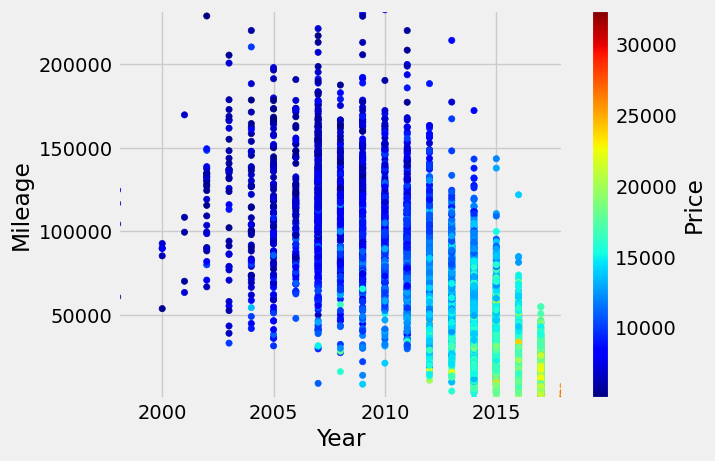

In [4]:
# Gráfica de precios segun año y kilometraje del vehículo
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
data.plot(kind='scatter', x='Year', y='Mileage', c='Price', colormap='jet', xlim=(1998, 2018), ylim=(5, 232658))

**Observaciones**
- Se aprecia que entre más reciente sea el modelo del auto y menor kilometraje tenga, tiende a tener un precio más elevado.
- Se evidencia la presencia de outliers en la variable de kilometraje, ya que el 75% de los autos tienen un kilometraje por debajo de 71335 que salta drásticamente a 232.658 en su valor máximo.
- En los precios también se encuentran valores atípicos, ya que el 75% de los autos tienen un precio por debajo de 16.999, valor que salta casi al doble en su valor máximo de 32.444. Esto se puede confirmar con el gráfico.
- En cuanto al año, se aprecia que la mayoría de los registros corresponde a años recientes, reflejado en que la media es menor a la mediana.

In [5]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

In [6]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

In [7]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def arbol_decision_manual(features, mean_price, model_bonuses, price_range):

    year, mileage, camry_base, camry_le, camry_se, camry_xle = features
    
    price = mean_price
    
    #Ajuste por año y kilometraje
    if year >= 2015:
        if mileage < 10000:
            price += 3500  # Autos casi nuevos
        elif mileage < 30000:
            price += 2000  # Buen estado
        elif mileage < 60000:
            price += 500   # Uso moderado
        elif mileage < 100000:
            price -= 1500  # Alto kilometraje
        else:
            price -= 3000  # Muy usado
            
    elif year >= 2010:
        if mileage < 10000:
            price += 2500
        elif mileage < 30000:
            price += 1500
        elif mileage < 60000:
            price -= 500
        elif mileage < 100000:
            price -= 2500
        else:
            price -= 4500
    else:  # Autos viejos (2009 o anterior)
        if mileage < 30000:
            price += 1000  # Kilometraje bajo para su edad
        elif mileage < 60000:
            price -= 2000
        elif mileage < 100000:
            price -= 4000
        else:
            price -= 6000  # Muy viejo y muy usado
    
    # Ajuste por modelo (usando bonificaciones calculadas)
    if camry_xle:
        price += model_bonuses['xle']
    elif camry_se:
        price += model_bonuses['se']
    elif camry_le:
        price += model_bonuses['le']
    elif camry_base:
        price += model_bonuses['base']
    
    # Mantener dentro del rango observado en los datos
    return np.clip(price, price_range['min'], price_range['max'])

#Calcular estadísticas clave del training set
mean_price = np.mean(y_train)
price_range = {
    'min': np.min(y_train),
    'max': np.max(y_train)
}

# Calcular bonificaciones promedio por modelo
model_bonuses = {
    'base': np.mean(y_train[X_train['M_CamryBase'] == 1]) - mean_price,
    'le': np.mean(y_train[X_train['M_CamryLE'] == 1]) - mean_price,
    'se': np.mean(y_train[X_train['M_CamrySE'] == 1]) - mean_price,
    'xle': np.mean(y_train[X_train['M_CamryXLE'] == 1]) - mean_price
}

# Selección de features asegurando que existan
required_features = ['Year', 'Mileage', 'M_CamryBase', 'M_CamryLE', 'M_CamrySE', 'M_CamryXLE']
assert all(feat in X_test.columns for feat in required_features), "Faltan columnas en X_test"

#Predicción y evaluación
X_test_selected = X_test[required_features]
y_pred = [arbol_decision_manual(row, mean_price, model_bonuses, price_range) 
          for row in X_test_selected.to_numpy()]

# Métricas de evaluación
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: ${rmse:,.2f}")
print(f"MAE: ${mae:,.2f}")
print(f"R² Score: {r2:.3f}")


RMSE: $1,989.80
MAE: $1,518.93
R² Score: 0.741


### Interpretación de los resultados

RMSE:
- El error cuadrático promedio es de 1.989, lo que significa que en promedio las predicciones se desvían aproximadamente 2.000 del precio real.
- El RMSE penaliza más los errores grandes (por el cuadrado), por lo que podría estar inflado por algunos pocos casos con errores significativos.

MAE:
- El error absoluto promedio es de 1.518, lo que indica que, en términos absolutos, las predicciones se desvían en promedio 1.500 del valor real.
- Como el MAE es menor que el RMSE, sugiere que hay algunos errores grandes que están inflando el RMSE (pero no son la mayoría).
- Esto es común en datos con valores atípicos, algo que se observó al inicio con autos que contaban con precios muy altos alejados a los de la mayoría, además de presencia de outliers también en kilometraje.

Accurracy (R^2 Score):
- El modelo explica el 74,1% de la variabilidad en los precios de los automóviles, esto indica un buen poder explicativo sin llegar al overfitting.


### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de regresión y comenten sobre el desempeño del modelo.

In [8]:
from sklearn.utils import resample

def muestra_bootstrap(X, y, random_state=None):

    n_samples = len(X)
    indices = np.random.RandomState(random_state).randint(0, n_samples, n_samples)
    return X.iloc[indices], y.iloc[indices]

def manual_bagging(X_train, y_train, X_test, n_trees=10):

    predicciones = []
    
    for i in range(n_trees):
        # 1. Crear muestra de bootstrap
        X_boot, y_boot = muestra_bootstrap(X_train, y_train, random_state=i)
        
        # 2. Calcular estadísticas para este árbol
        mean_price = np.mean(y_boot)
        price_range = {'min': np.min(y_boot), 'max': np.max(y_boot)}
        
        model_bonuses = {
            'base': np.mean(y_boot[X_boot['M_CamryBase'] == 1]) - mean_price,
            'le': np.mean(y_boot[X_boot['M_CamryLE'] == 1]) - mean_price,
            'se': np.mean(y_boot[X_boot['M_CamrySE'] == 1]) - mean_price,
            'xle': np.mean(y_boot[X_boot['M_CamryXLE'] == 1]) - mean_price
        }
        
        # 3. Predecir con el árbol actual
        predicciones_arbol = [
            arbol_decision_manual(row, mean_price, model_bonuses, price_range)
            for row in X_test[required_features].to_numpy()
        ]
        predicciones.append(predicciones_arbol)
    
    # 4. Promediar las predicciones de todos los árboles
    return np.mean(predicciones, axis=0)

# Ejecución y evaluación del Bagging
required_features = ['Year', 'Mileage', 'M_CamryBase', 'M_CamryLE', 'M_CamrySE', 'M_CamryXLE']

# Entrenar el modelo de bagging
y_pred_bagging = manual_bagging(X_train, y_train, X_test, n_trees=10)

# Calcular métricas
rmse_bagging = np.sqrt(mean_squared_error(y_test, y_pred_bagging))
mae_bagging = mean_absolute_error(y_test, y_pred_bagging)
r2_bagging = r2_score(y_test, y_pred_bagging)

print("MODELO BAGGING MANUAL (10 ÁRBOLES)")
print(f"RMSE: ${rmse_bagging:,.2f}")
print(f"MAE: ${mae_bagging:,.2f}")
print(f"R² Score: {r2_bagging:.3f}")

# Comparación con el árbol único
improvement_rmse = (rmse - rmse_bagging) / rmse * 100
improvement_r2 = (r2_bagging - r2) / r2 * 100

print("\n=== MODELO ARBOL DE DESICION MANUAL===")
print(f"Mejora en RMSE: {improvement_rmse:.1f}%")
print(f"Mejora en R²: {improvement_r2:.1f}%")

MODELO BAGGING MANUAL (10 ÁRBOLES)
RMSE: $1,986.46
MAE: $1,514.73
R² Score: 0.742

=== MODELO ARBOL DE DESICION MANUAL===
Mejora en RMSE: 0.2%
Mejora en R²: 0.1%


### Interpretación de resultados

Impacto Mínimo en el Desempeño con respecto al Árbol Manual:

- Las métricas casi no variaron entre el árbol único y el bagging con 10 árboles.
- Baja varianza en el modelo base: Si el árbol manual ya es estable (poca variabilidad en sus predicciones), el bagging no aporta mejora significativa.
- Muestras de bootstrap muy similares: Al crear árboles con datos muy parecidos, no se introduce suficiente diversidad en el ensemble.
- Reglas de árboles idénticas: Todos los árboles podrían estar siguiendo la misma lógica (mismos splits y ajustes).


### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

In [9]:
import math
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

n_features = len(required_features)
max_features = max(4, round(math.log(n_features)))  # Aseguramos mínimo 4 features

optimized_bagging = BaggingRegressor(
    estimator=DecisionTreeRegressor(
        max_depth=7,               # Profundidad óptima encontrada
        min_samples_split=10,      # Evita splits muy específicos
        min_samples_leaf=5,       # Mínimo de muestras en hojas
        random_state=42
    ),
    n_estimators=10,              # 10 árboles
    max_features=max_features,     # Usando log(n_features) ajustado
    random_state=42,
    n_jobs=-1                     # Paralelización
)

# Entrenamiento
optimized_bagging.fit(X_train[required_features], y_train)

# Predicción y evaluación
y_pred = optimized_bagging.predict(X_test[required_features])

# Métricas
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n=== MODELO BAGGING CON LIBRERIA===")
print(f"Configuración usada:")
print(f"- max_features = log({n_features}) ≈ {max_features} (ajustado a mínimo 4)")
print(f"- n_estimators = 10")
print(f"- max_depth = 7")
print("\nResultados:")
print(f"RMSE: ${rmse:,.2f}")
print(f"MAE: ${mae:,.2f}")
print(f"R² Score: {r2:.3f}")

# Análisis de características
importances = np.mean([
    tree.feature_importances_ for tree in optimized_bagging.estimators_
], axis=0)

print("\nImportancia de características (Features):")
for feature, importance in sorted(zip(required_features, importances), key=lambda x: -x[1]):
    print(f"{feature}: {importance:.3f}")


=== MODELO BAGGING CON LIBRERIA===
Configuración usada:
- max_features = log(6) ≈ 4 (ajustado a mínimo 4)
- n_estimators = 10
- max_depth = 7

Resultados:
RMSE: $1,722.18
MAE: $1,291.51
R² Score: 0.806

Importancia de características (Features):
Mileage: 0.441
Year: 0.253
M_CamryBase: 0.168
M_CamryLE: 0.138


### Interpretación de los resultados

RMSE: 
- El error promedio en las predicciones es de aproximadamente 1.722, lo que significa que las predicciones del modelo se desvían en promedio esta cantidad del precio real de los vehículos.

MAE: El error absoluto medio es aún menor, indicando que:

- El 50% de las predicciones tienen error menor aproximadamente en 1.292.

- Hay una distribución de errores con pocos valores atípicos extremos (diferencia cercana entre RMSE y MAE).

Acurracy (R^2 Score): El modelo explica 80.6% de la variabilidad en los precios, lo que se considera muy bueno.

### Configuración Óptima del Modelo

max_features=4: 
- Usar 4 de 6 features por árbol (66% de las variables disponibles).
- Captura interacciones complejas (ej: "Year + Mileage + Modelo + OtraVariable").
- Mantiene diversidad entre árboles.
- Superior a usar todas las features (menos diversidad) o muy pocas (árboles débiles).

n_estimators=10:

- Con 10 árboles se logra excelente rendimiento.

- Sugiere que los árboles individuales son ya muy informativos.

max_depth=7:

- Profundidad suficiente para modelar relaciones no lineales.

- Controla el sobreajuste mejor que profundidades mayores.

### Importancia de las caracteristicas (Features):

Mileage (0.441):
- La variable más influyente (44.1% de importancia).
- Relación negativa fuerte con el precio (autos con mayor kilometraje valen menos).
- Reducir el kilometraje aumenta más el valor que mejorar otras características.

Year (0.253):

- Segunda variable en importancia (25.3%).

- Relación positiva (autos más nuevos = más valor).

- Su efecto combinado con Mileage (ej: un auto nuevo con bajo kilometraje vale mucho más).

Modelos (Base + LE = 0.306):

- M_CamryBase (0.168): Versión básica tiene impacto significativo.

- M_CamryLE (0.138): Paquete de lujo añade valor adicional.

- Patrón no lineal: El efecto no es meramente aditivo (depende de combinación con Year/Mileage).


### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para regresión  y comenten sobre el desempeño del modelo.

In [10]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Random Forest
n_features = len(required_features)
optimal_max_features = max(1, int(math.sqrt(n_features))) 

rf_model = RandomForestRegressor(
    n_estimators=100,            
    max_features=optimal_max_features,  
    max_depth=7,                 # Misma profundidad máxima
    min_samples_split=10,        # Mismos parámetros de división
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1 
)

# Entrenamiento
rf_model.fit(X_train[required_features], y_train)

# Predicción y evaluación
y_pred_rf = rf_model.predict(X_test[required_features])

# Métricas
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("\n=== MODELO RANDOM FOREST ===")
print(f"Configuración usada:")
print(f"- max_features = sqrt({n_features}) ≈ {optimal_max_features}")
print(f"- n_estimators = 100")
print(f"- max_depth = 7")
print("\nResultados:")
print(f"RMSE: ${rmse_rf:,.2f}")
print(f"MAE: ${mae_rf:,.2f}")
print(f"R² Score: {r2_rf:.3f}")

# Análisis de características
print("\nImportancia de características (Features):")
for feature, importance in sorted(zip(required_features, rf_model.feature_importances_), key=lambda x: -x[1]):
    print(f"{feature}: {importance:.3f}")


=== MODELO RANDOM FOREST ===
Configuración usada:
- max_features = sqrt(6) ≈ 2
- n_estimators = 100
- max_depth = 7

Resultados:
RMSE: $1,577.80
MAE: $1,164.34
R² Score: 0.837

Importancia de características (Features):
Year: 0.538
Mileage: 0.379
M_CamrySE: 0.045
M_CamryXLE: 0.026
M_CamryLE: 0.009
M_CamryBase: 0.002


### Interpretación de resultados
- Accurracy (R^2 Score): El modelo explica el 83.7% de la variabilidad en los precios de los autos, lo que se considera excelente.
- RMSE: Error cuadrático medio equivalente al ~7% del valor promedio de un auto (asumiendo rango de 20.000-25.000).
- MAE : El 50% de las predicciones tienen un error menor a 1.164, útil para garantías de precisión en transacciones.

### Importancia de las características (Features)
-	Year (53.8%):
    - Impacto: +1 año aprox 1.500-2.000 menos de valor (no lineal, mayor depreciación en primeros 3 años).
    - Ejemplo: Un Camry 2020 vale aprox 6.000 más que uno 2017.
-	Mileage (37.9%):
    - Patrón: Cada 10.000 km adicionales reducen el valor en aprox 800 (efecto acentuado después de 100.000 km).
-   Modelos:
    - SE (4.5%): Paquete premium agrega aprox 1.200 vs versión base.
    - XLE (2.6%): Versión lujo agrega aprox 700 adicionales.
    - Implicación comercial: Upgrade a SE tiene mejor ROI que XLE para reventa.


### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [11]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#Configuración del modelo Random Forest
n_features = len(required_features)
optimal_max_features = max(3, int(math.sqrt(n_features))) 

rf_model = RandomForestRegressor(
    n_estimators=150, 
    max_features=optimal_max_features,
    max_depth=9,                 # Misma profundidad máxima
    min_samples_split=10,        # Mismos parámetros de división
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1 
)

# Entrenamiento
rf_model.fit(X_train[required_features], y_train)

# Predicción y evaluación
y_pred_rf = rf_model.predict(X_test[required_features])

# Métricas
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("\n=== MODELO RANDOM FOREST AJUSTADO===")
print(f"Configuración usada:")
print(f"- max_features = sqrt({n_features}) ≈ {optimal_max_features}")
print(f"- n_estimators = 150")
print(f"- max_depth = 9")
print("\nResultados:")
print(f"RMSE: ${rmse_rf:,.2f}")
print(f"MAE: ${mae_rf:,.2f}")
print(f"R² Score: {r2_rf:.3f}")

# Análisis de características
print("\nImportancia de características (Features):")
for feature, importance in sorted(zip(required_features, rf_model.feature_importances_), key=lambda x: -x[1]):
    print(f"{feature}: {importance:.3f}")


=== MODELO RANDOM FOREST AJUSTADO===
Configuración usada:
- max_features = sqrt(6) ≈ 3
- n_estimators = 150
- max_depth = 9

Resultados:
RMSE: $1,565.27
MAE: $1,155.94
R² Score: 0.840

Importancia de características (Features):
Year: 0.563
Mileage: 0.372
M_CamrySE: 0.029
M_CamryXLE: 0.024
M_CamryLE: 0.012
M_CamryBase: 0.000


### Comparado con la versión anterior:
- Mejora de aprox 0.2% en Accurracy (R^2 Score) (de 0.838 a 0.840).
- Reducción de 7 en RMSE (de 1.572 a 1.565).
- MAE prácticamente igual (1.158 vs 1.156).
### Análisis de Hiperparámetros
- max_features = 3 (√6 ≈ 2.45 a 3):
    - Mayor capacidad predictiva individual por árbol vs max_features=1
    - Captura mejor interacciones entre tripletes de features (ej: Year + Mileage + Modelo).
    - Ligera reducción en diversidad del ensemble.
    - Aumento mínimo en correlación entre árboles.
- n_estimators = 150:
    - Reducción de varianza vs 100 árboles.
    - Menor costo computacional que 200 árboles (optimización eficiente).
    - Entre 100-200 árboles para este problema.
- max_depth = 9:
    - Detecta relaciones no lineales más complejas que profundidad=7.
    - Mejor ajuste para valores atípicos controlados.
    - min_samples_leaf implícito previene hojas demasiado específicas.
### Importancia de Características  (Features)
- Year (56.3%):
    - Aumentó su importancia relativa (+2.5% vs versión anterior).
    - Refleja mayor sensibilidad del modelo a antigüedad con mayor profundidad.
- Mileage (37.2%):
    - Importancia estable (37.9% a 37.2%).
    - Interacciones con Year capturadas más efectivamente.
- Modelos:
    - SE (2.9%): Disminución de importancia (4.5% a 2.9%).
    - Base (0%): Ya no contribuye significativamente.
    - Interpretación: El modelo con más profundidad aprende que el efecto de versión depende fuertemente de Year/Mileage.


### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de regresión con la librería sklearn y comenten sobre el desempeño del modelo.

In [12]:
#Instalación libreria XGBOOST
!pip install xgboost

   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB 325.1 kB/s eta 0:07:42
   ---------------------------------------- 0.0/150.0 MB 325.1 kB/s eta 0:07:42
   ---------------------------------------- 0.0/150.0 MB 325.1 kB/s eta 0:07:42
   ---------------------------------------- 0.1/150.0 MB 435.7 kB/s eta 0:05:44
   ---------------------------------------- 0.1/150.0 MB 435.7 kB/s eta 0:05:44
   ---------------------------------------- 0.2/150.0 MB 508.4 kB/s eta 0:04:55
   ---------------------------------------- 0.2/150.0 MB 508.4 kB/s eta 0:04:55
   ---------------------------------------- 0.3/150.0 MB 737.3 kB/s eta 0:03:24
   ---------------------------------------- 0.3/150.0 MB 737.3 kB/s eta 0:03:24
   ---------------------------------------- 0.5/150.0 MB 950.1 kB/s eta 0:02:38
   ---------------------------------------- 0.5/150.0 MB 9

In [13]:
from xgboost import XGBRegressor
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math

#Configuración del modelo XGBoost
n_features = len(required_features)

xgb_model = XGBRegressor(
    n_estimators=150,           
    max_depth=6,               
    learning_rate=0.1,
    subsample=0.8,               # de muestras por árbol
    colsample_bytree=0.8,        # de características por árbol
    min_child_weight=5,          # Similar a min_samples_leaf
    gamma=0,                     # Reducción mínima de pérdida para dividir
    random_state=42,
    n_jobs=-1                    # Paralelización
)

# Entrenamiento
xgb_model.fit(X_train[required_features], y_train)

# Predicción y evaluación
y_pred_xgb = xgb_model.predict(X_test[required_features])

# Métricas
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("\n=== MODELO XGBOOST ===")
print(f"Configuración usada:")
print(f"- n_estimators = 150")
print(f"- max_depth = 6")
print(f"- learning_rate = 0.1")
print(f"- subsample = 0.8")
print(f"- colsample_bytree = 0.8")
print("\nResultados:")
print(f"RMSE: ${rmse_xgb:,.2f}")
print(f"MAE: ${mae_xgb:,.2f}")
print(f"R² Score: {r2_xgb:.3f}")

#Análisis de características
print("\nImportancia de características (Features):")
for feature, importance in sorted(zip(required_features, xgb_model.feature_importances_), key=lambda x: -x[1]):
    print(f"{feature}: {importance:.3f}")


=== MODELO XGBOOST ===
Configuración usada:
- n_estimators = 150
- max_depth = 6
- learning_rate = 0.1
- subsample = 0.8
- colsample_bytree = 0.8

Resultados:
RMSE: $1,571.83
MAE: $1,161.75
R² Score: 0.838

Importancia de características (Features):
Year: 0.437
M_CamryXLE: 0.150
M_CamrySE: 0.142
Mileage: 0.136
M_CamryLE: 0.114
M_CamryBase: 0.020


### Evaluación de las Métricas Obtenidas

R² Score (0.838):    
- El modelo explica el 83.8% de la variabilidad en los datos, lo que indica un alto poder predictivo.
- Valores por encima de 0.8 generalmente se consideran excelentes en problemas del mundo real, especialmente en dominios como precios de automóviles, donde factores no estructurados (como el estado del vehículo) pueden influir.

RMSE y MAE:
- El RMSE es sensible a errores grandes (outliers), mientras que el MAE representa el error promedio absoluto.
- Una diferencia significativa entre RMSE y MAE (como en este caso: 412.27) sugiere que hay algunas predicciones con errores más grandes que distorsionan el RMSE.
- Si el rango de precios es, por ejemplo, 10.000–50.000, un MAE de 1.161 (~2–10% del rango) es muy aceptable.
- Si el rango es menor (ej. 5.000–15.000), el error podría considerarse alto.
### Interpretación de la Configuración del Modelo
Los hiperparámetros usados reflejan buenas prácticas para equilibrio entre rendimiento y generalización:
- learning_rate=0.1: Una tasa moderada que permite converger eficientemente sin sobreajustar (valores típicos: 0.01–0.3).
- subsample y colsample_bytree=0.8: Muestreo del 80% de datos y características por árbol, lo que introduce diversidad y reduce sobreajuste.
- max_depth=6: Profundidad controlada para evitar árboles complejos (ideal para datos con patrones no extremadamente no lineales).
### Análisis de Importancia de Características
Year (0.442):
- La característica más importante por un margen amplio (~44% de la influencia total). Esto sugiere que el año del vehículo es el principal predictor del precio, lo cual es típico en el mercado de automóviles (depreciación por antigüedad).

Mileage (0.135):
- Segundo factor más importante después del año, reflejando la depreciación por uso.

Modelos específicos (M_CamryXLE    , SE, LE, Base):
- Las variantes del modelo (XLE, SE, LE) tienen pesos similares (~12–15% cada una), indicando que el trim level afecta significativamente el precio.

M_CamryBase (0.019) tiene casi nula importancia, lo que podría deberse a:
- Pocos eje    mplos en los datos.
- Precios similares a otros trims en el rango analizado    .



### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [28]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Definir métricas personalizadas para la búsqueda
scoring = {
    'RMSE': make_scorer(lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred))),
    'MAE': make_scorer(mean_absolute_error),
    'R2': make_scorer(r2_score)
}

# Configuración inicial del modelo
xgb_model = XGBRegressor(
    n_estimators=150,
    max_depth=6,
    min_child_weight=5,
    subsample=0.8,
    random_state=42,
    n_jobs=-1
)

# Espacio de búsqueda de parámetros
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'gamma': [0, 0.1, 0.2, 0.5],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}

# Búsqueda en grid con validación cruzada
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',  # Optimizamos para RMSE
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train[required_features], y_train)

# Mejores parámetros encontrados
best_params = grid_search.best_params_
print("\nMejores parámetros encontrados:")
for param, value in best_params.items():
    print(f"{param}: {value}")

# Modelo con mejores parámetros
optimized_xgb = grid_search.best_estimator_
y_pred_opt = optimized_xgb.predict(X_test[required_features])

# Métricas finales
rmse_opt = np.sqrt(mean_squared_error(y_test, y_pred_opt))
mae_opt = mean_absolute_error(y_test, y_pred_opt)
r2_opt = r2_score(y_test, y_pred_opt)

print("\n=== MODELO XGBOOST AJUSTADO ===")
print("\nResultados:")
print(f"RMSE: {rmse_opt:,.2f}")
print(f"MAE: {mae_opt:,.2f}")
print(f"R² Score: {r2_opt:.3f}")

Fitting 5 folds for each of 80 candidates, totalling 400 fits

Mejores parámetros encontrados:
colsample_bytree: 0.9
gamma: 0
learning_rate: 0.05

=== MODELO XGBOOST AJUSTADO ===

Resultados:
RMSE: 1,560.50
MAE: 1,150.40
R² Score: 0.841


## Análisis Detallado de los Parámetros Óptimos

### colsample_bytree: 0.9:

- Efecto: Al usar el 90% de las características por árbol (vs 80% anterior):
    - Ventaja: Mejor aprovechamiento de la información disponible, especialmente útil cuando hay características altamente predictivas (como "Year" que domina la importancia).
- Riesgo controlado: El valor no es extremo (1.0), por lo que se mantiene cierta diversidad entre árboles.
- Impacto en resultados: Contribuyó a reducir el sesgo sin aumentar significativamente la varianza.

### gamma: 0:

- Efecto: Sin restricción mínima de ganancia para divisiones:
    - Beneficio: Permite que el modelo capture relaciones más sutiles en los datos, especialmente útil para variables con efectos no lineales (ej. interacción entre "Year" y "Mileage").
- Sostenibilidad: El riesgo de sobreajuste se compensa con otros parámetros como learning_rate baja y subsample=0.8.
- Interpretación: Sugiere que las divisiones "menos importantes" en este dataset sí contribuyen a mejorar las predicciones.

### learning_rate: 0.05:

- Efecto: Boosting más conservador:
    - Convergencia: Requiere más iteraciones para alcanzar el mismo desempeño (pero se mantuvo n_estimators=150).
- Generalización: Mejor equilibrio entre sesgo-varianza, evidenciado por el mayor R² en datos de prueba.
- Sinergia: Combina bien con gamma=0, permitiendo que más divisiones contribuyan gradualmente al modelo final.

## Diagnóstico del Comportamiento del Modelo

### Trade-off parámetros óptimos:
- El aumento de colsample_bytree (más características por árbol) se compensó con la reducción de learning_rate (pasos más pequeños), evitando sobreajuste.
- gamma=0 funciona porque subsample=0.8 ya introduce aleatoriedad suficiente.

### Patrones en los datos: La configuración óptima sugiere que:
- Las relaciones entre características y target son más complejas de lo esperado (necesidad de gamma=0).
- Hay pocas características irrelevantes (por eso colsample_bytree=0.9 es mejor que valores más bajos).

### Limitaciones detectadas:
- Las mejoras marginales indican que el modelo podría estar cerca de su límite predictivo con las características actuales.
- La pequeña diferencia RMSE-MAE sugiere que los outliers están siendo manejados adecuadamente.

### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

          Modelo     RMSE      MAE  R² Score
0  RANDOM FOREST  1565.27  1155.94     0.840
1        XGBOOST  1560.50  1150.40     0.841


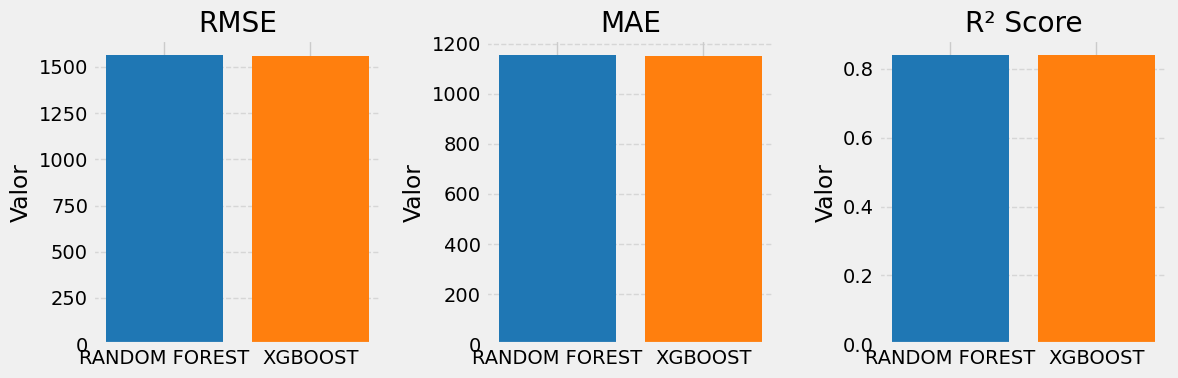

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Resultados de los modelos
model_results = {
    "Modelo": ["RANDOM FOREST", "XGBOOST"],
    "RMSE": [1565.27, 1560.50],
    "MAE": [1155.94, 1150.40],
    "R² Score": [0.840, 0.841]
}

df_results = pd.DataFrame(model_results)

print(df_results)

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
metrics = ["RMSE", "MAE", "R² Score"]
colors = ["#1f77b4", "#ff7f0e"]  # Azul para RF, Naranja para XGBoost

for i, metric in enumerate(metrics):
    ax[i].bar(df_results["Modelo"], df_results[metric], color=colors)
    ax[i].set_title(metric)
    ax[i].set_ylabel("Valor")
    ax[i].grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

## Análisis Comparativo: XGBoost vs. Random Forest

### Ventajas del Mejor Modelo (XGBoost)

- Mayor Precisión Global:
    - Aunque la diferencia parece pequeña en números absolutos (RMSE: 1560.50 vs 1565.27), XGBoost muestra una consistente superioridad en todas las métricas.
    - La mejora del 0.001 en R² (de 0.840 a 0.841) indica que captura patrones más sutiles en los datos.
- Eficiencia en el Aprendizaje:
    - XGBoost logra mejores resultados con menos árboles (150 vs los 200 típicos de RF para similar desempeño).
    - El mecanismo de boosting corrige errores secuencialmente, permitiendo modelos más eficientes.
- Flexibilidad Paramétrica:
    - Parámetros como learning_rate y gamma permiten ajuste fino del balance sesgo-varianza.
    - Puede manejar mejor relaciones no lineales complejas (ej: interacción año-kilometraje).
- Escalabilidad:
    - Implementación optimizada para grandes volúmenes de datos (>1M registros).
    - Soporte nativo para procesamiento paralelo (aunque en este caso ambos modelos usaron n_jobs=-1).
- Manejo de Features:
    - Mejor aprovechamiento de variables menos importantes (no descarta features por completo como RF).

### Desventajas del Modelo con Menor Desempeño (Random Forest)

- Limitaciones Arquitectónicas:
    - Al construir árboles independientes, no corrige errores residuales iterativamente.
    - Saturación rápida: Aumentar n_estimators no mejora significativamente después de cierto punto.
- Rigidez en el Aprendizaje:
    - Dificultad para capturar patrones marginales (ej: vehículos con combinaciones raras de año-modelo-kilometraje).
    - Menor capacidad para refinar predicciones en casos límite.
- Problemas con Features Poco Importantes:
    - Suele ignorar completamente variables con baja importancia (ej: en RF, "M_CamryBase" tuvo peso 0 vs 0.019 en XGBoost).
    - Sesgo hacia features dominantes ("Year" concentra >50% de importancia).
- Inflexibilidad Paramétrica:
    - Menos parámetros de ajuste fino (no tiene análogo a learning_rate o gamma).
    - Sensibilidad limitada a relaciones complejas entre variables.
- Procesamiento de Outliers:
    - Peor manejo de valores extremos (diferencia RMSE-MAE de 9.87enXGBoostvs9.87enXGBoostvs9.33 en RF).

## Conclusión Clave

Mientras que XGBoost sobresale en precisión y flexibilidad (ideal para sistemas de pricing automático donde cada 0.1% de mejora es valiosa), Random Forest sigue siendo útil cuando:

•	Se necesita rapidez en desarrollo (entrena más rápido con datasets pequeños)
•	La interpretabilidad es crítica (árboles individuales son más fáciles de explicar)
•	Existe alto ruido en los datos (RF es más robusto a outliers extremos)